# **Credit Limit** Prediction Using Deep Neural Networks

## Authors
- **Kianoosh Vadaei**: Researcher
- **Melika Shirian**: Researcher

### Contact Information
- Kianoosh Vadaei: [email](mailto:kia.vadaei@gmail.com), [LinkedIn](https://www.linkedin.com/in/kianoosh-vadaei-0aa58611b/), [GitHub](https://github.com/kia-vadaei)
- Melika Shirian: [email](mel.shirian@gmail.com), [LinkedIn](https://www.linkedin.com/in/melika-shirian-b8477a254/), [GitHub](https://github.com/MelikaShirian12)


## Introduction
This notebook provides an analysis of **Credit Limit** Prediction. We will cover the following steps:
1. Data Loading
2. Data Preprocessing
3. Exploratory Data Analysis
4. Model Building
5. Model Evaluation
6. Conclusion

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Model Building](#Model-Building)
6. [Model Evaluation](#Model-Evaluation)
7. [Conclusion](#Conclusion)



In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from dataset import Dataset
from models import OneLayerModel, TwoLayerModel, ClassicModels, ExtraTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}')

The device is: cuda


<a id='Data-Loading'></a>
## **Data Loading**
In this section, we will load the dataset and display the first few rows to understand its structure.


In [3]:
dataset = Dataset(data_path='../data/polynomial_dataset.csv', target_col='Credit_Limit')
dataset.load_data()

print(f'The dataset is shown below:')
display(dataset.data_df)

The dataset is shown below:


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Income_Category_Unknown Card_Category_Gold,Income_Category_Unknown Card_Category_Platinum,Income_Category_Unknown Card_Category_Silver,Card_Category_Gold^2,Card_Category_Gold Card_Category_Platinum,Card_Category_Gold Card_Category_Silver,Card_Category_Platinum^2,Card_Category_Platinum Card_Category_Silver,Card_Category_Silver^2,Credit_Limit
0,768805383.0,45.0,3.0,39.0,5.0,1.0,3.0,777.0,1.335,1144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12691.0
1,818770008.0,49.0,5.0,44.0,6.0,1.0,2.0,864.0,1.541,1291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8256.0
2,713982108.0,51.0,3.0,36.0,4.0,1.0,0.0,0.0,2.594,1887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3418.0
3,769911858.0,40.0,4.0,34.0,3.0,4.0,1.0,2517.0,1.405,1171.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3313.0
4,709106358.0,40.0,3.0,21.0,5.0,1.0,0.0,0.0,2.175,816.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,718673358.0,35.0,3.0,30.0,5.0,3.0,4.0,1528.0,0.728,2137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13590.0
10163,715207458.0,46.0,1.0,39.0,2.0,2.0,1.0,1074.0,0.514,4802.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2029.0
10164,803665983.0,52.0,0.0,46.0,3.0,2.0,4.0,2184.0,0.592,3829.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2742.0
10165,713183508.0,39.0,1.0,36.0,1.0,3.0,2.0,1158.0,0.821,4861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2751.0


In [ ]:
dataset.data_df.drop(['Credit_Limit'], axis=1)

In [ ]:
dataset.expand_dataset(n_samples=100000, noise_level=.7)

In [ ]:
dataset.save_expanded_dataset()

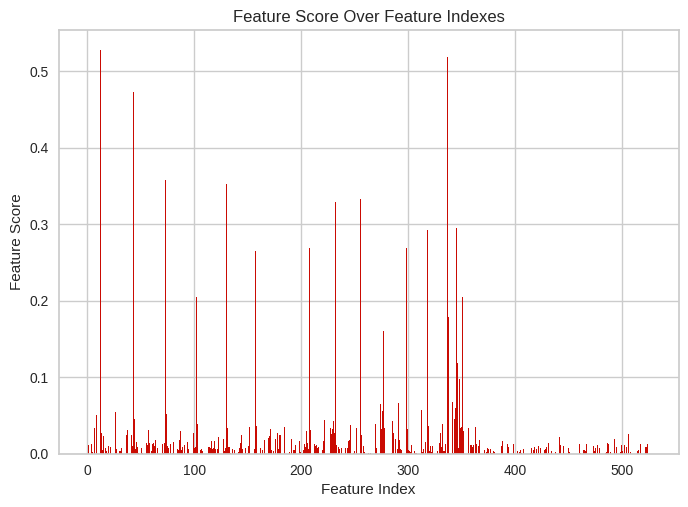

In [4]:
dataset.preprocess_data(features_score_plot=True, random_state=112, pca=False, feature_selection=True, is_expanded=False)

In [ ]:
print(f'number of selected features: {len(dataset.selected_feature_indices)}')

In [ ]:
dataset.selected_feature_indices

In [ ]:
dataset.data_df.select_dtypes(include='object')

In [5]:
df = pd.read_csv('../data/CreditPrediction.csv')
df = df.drop_duplicates()
df = pd.get_dummies(df)
df = df.fillna(0)

upper=df['Credit_Limit'].quantile(0.4)
lower=df['Credit_Limit'].quantile(0.6)

index=df[(df['Credit_Limit']>=lower)|(df['Credit_Limit']<=upper)].index

df.drop(index,inplace=True)

df_x = df.drop('Credit_Limit', axis=1)
df_y = df['Credit_Limit']


In [ ]:
# for i in range(dataset.X_train.shape[1]):
#     plt.figure()
#     plt.boxplot(dataset.X_train[i], vert=False)
#     plt.title("Boxplot of the sample after treating the outliers")

# plt.boxplot(dataset.data_df['Credit_Limit'], vert=False)
# dataset.data_df['Credit_Limit'].describe()
# # dataset.target.describe()
# # dataset.target.describe()
# dataset.X_train[10].describe()

dataset.data_df['Credit_Limit'].describe()

In [ ]:
dataset.X_test.shape

## **Model Building**

In [6]:
dataset.prepare_for_model()
dataset.to_device(device)


In [10]:
nn_model = TwoLayerModel(dataset.num_features , 8, device=device)
nn_model = nn_model.to(device)

100%|██████████| 30000/30000 [01:08<00:00, 436.91it/s]


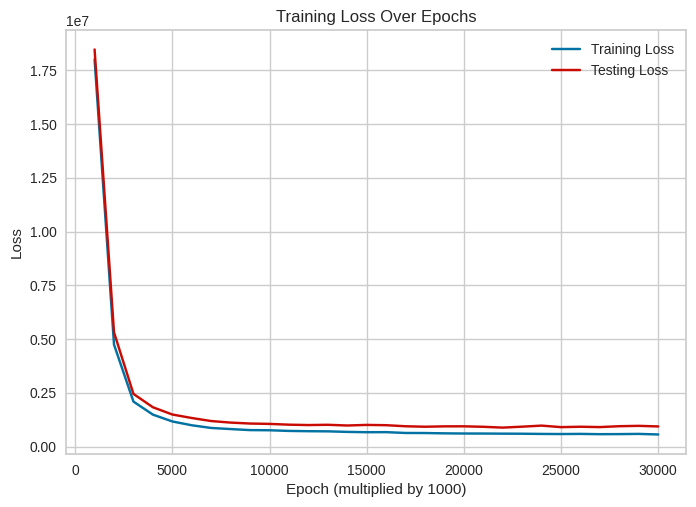

In [11]:
nn_model.fit(dataset.X_train, dataset.target_train, dataset.X_test, dataset.target_test, show_plot=True)

In [12]:
nn_model.test_report(dataset.X_test, dataset.target_test)

,Model,MSE,MAE,RMSE,R2,TT (Sec)
0,TwoLayerModel,955040.625,653.995361,977.2618,0.614682,68.84544


In [ ]:
dataset.X_train.shape

In [13]:
X = torch.vstack((dataset.X_train, dataset.X_test))
y = torch.vstack((dataset.target_train, dataset.target_test))

classic_models = ClassicModels()
classic_models.classical_report(X, y)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(5060, 333)"
4,Transformed data shape,"(5060, 333)"
5,Transformed train set shape,"(3542, 333)"
6,Transformed test set shape,"(1518, 333)"
7,Numeric features,332
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,342.7412,570809.3996,752.2273,0.8155,0.1496,0.0727,1.2460
rf,Random Forest Regressor,365.9956,571500.6449,754.0451,0.8151,0.1501,0.0776,2.6320
gbr,Gradient Boosting Regressor,451.5673,616205.4861,782.9800,0.8008,0.1553,0.0947,1.3440
lightgbm,Light Gradient Boosting Machine,385.9368,625551.5405,787.6223,0.7977,0.1553,0.0814,2.4780
lasso,Lasso Regression,556.4778,689943.7219,829.3033,0.7770,0.1688,0.1197,0.2130
ridge,Ridge Regression,569.7732,708121.5875,840.1972,0.7711,0.1709,0.1224,0.0340
llar,Lasso Least Angle Regression,574.0104,708931.5719,840.1455,0.7711,0.1722,0.1244,0.0390
br,Bayesian Ridge,590.4480,733008.3562,855.0100,0.7630,0.1750,0.1273,0.0590
huber,Huber Regressor,567.5039,742755.0429,859.4385,0.7600,0.1709,0.1183,0.5540
par,Passive Aggressive Regressor,614.6536,798855.2551,891.4116,0.7420,0.1803,0.1296,0.0740


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,354.1254,622391.9516,788.9182,0.7997,0.1541,0.0735


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,target,prediction_label
2198,-0.583292,1.243192,-0.544148,0.805980,0.890560,-0.159727,-0.147804,1.594002,-0.852613,-0.677731,...,0.0,0.0,1.290385,0.0,-0.366277,0.0,0.0,0.0,3069.0,3071.52
3551,-0.671993,0.421677,-1.834374,-1.409077,0.941887,0.001829,-0.283887,0.292048,-0.852613,1.475511,...,0.0,0.0,-0.774962,0.0,2.730177,0.0,0.0,0.0,5455.0,5460.60
4982,-0.552661,0.695516,-1.834374,0.805980,-1.613458,-0.189543,1.122302,-1.271113,-0.852613,-0.677731,...,0.0,0.0,-0.774962,0.0,-0.366277,0.0,0.0,0.0,4440.0,4870.62
288,-0.545949,-1.358271,0.100966,-1.409077,1.362279,-0.813252,-1.553993,1.851128,-0.852613,-0.677731,...,0.0,0.0,1.290385,0.0,-0.366277,0.0,0.0,0.0,3182.0,3173.52
4174,-0.481355,-0.262918,0.100966,0.805980,0.338185,-0.927650,-1.644715,-0.250773,1.172865,-0.677731,...,0.0,0.0,-0.774962,0.0,-0.366277,0.0,0.0,0.0,6387.0,6338.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,-0.773796,0.010920,1.391192,-1.409077,-1.613458,0.065113,1.349106,-1.271113,-0.852613,1.475511,...,0.0,0.0,1.290385,0.0,-0.366277,0.0,0.0,0.0,3069.0,4371.41
2496,-0.622050,-1.905948,1.391192,-0.301548,-1.613458,0.098580,0.850136,-1.271113,-0.852613,-0.677731,...,0.0,0.0,1.290385,0.0,-0.366277,0.0,0.0,0.0,3069.0,4702.15
3400,0.974507,0.832435,0.746079,0.805980,-0.618694,0.120486,1.122302,-0.250773,-0.852613,-0.677731,...,0.0,0.0,1.290385,0.0,-0.366277,0.0,0.0,0.0,3261.0,3308.99
667,-0.471483,-1.221352,-0.544148,-1.409077,1.099534,-0.438723,-0.238526,1.912349,-0.852613,1.475511,...,0.0,0.0,-0.774962,0.0,-0.366277,0.0,0.0,0.0,3069.0,3074.76


In [ ]:
extra_tree_rg = ExtraTreeRegressor()
extra_tree_rg.fit(dataset.X_train, dataset.target_train)

In [ ]:
df_x = np.array(df_x)
df_y = np.array(df_y)
s = dataset.selected_feature_indices
df_x2 = df_x[:,s]
x_test = dataset.X_test.to(torch.device('cpu'))
y_test = dataset.target_test.to(torch.device('cpu'))
report = extra_tree_rg.test_report(df_x2,df_y)
report['Model'] = 'Extra Tree Regressor'
report

In [ ]:
def fix_columns( df_to_fix):
    final_df = pd.DataFrame()

    data_df = dataset.data_df.iloc[:,:-1]
    data_df = data_df.drop('Credit_Limit', axis=1)
    num_cols = data_df.select_dtypes(exclude='object').columns
    cat_cols = data_df.select_dtypes(include='object').columns

    for i in range(len(num_cols)):
        final_df[num_cols[i]] = df_to_fix[i]
    for j in range(i + 1, 18):
        final_df[cat_cols[j-i-1]] = df_to_fix[j]
    return final_df

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

cat_cols = list(dataset.data_df.select_dtypes(include='object').columns)

X = dataset.data_df.drop(['Credit_Limit'], axis=1)
X = dataset.fix_missing_values(X)
X = fix_columns(X)
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
cols = list(X.columns)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(cols))
poly_df['Credit_Limit'] = dataset.data_df['Credit_Limit']

poly_df.to_csv('../data/polynomial_dataset.csv', index=False)


In [ ]:
a = pd.read_csv('../data/polynomial_dataset.csv')
a.drop('Credit_Limit',axis=1)